In [685]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure

%matplotlib inline

In [686]:
# Preprocessing
src = cv2.imread('./img1.jpg');
# src = cv2.resize(src, (300,300))
img = cv2.cvtColor(src,cv2.COLOR_BGR2RGB);
print(img.shape[0], img.shape[1])


702 563


# 3.1 Image pixel adjustment

In [687]:
# Parameters
gamma = [0.1, 1, 3, 5, 10]
a = 1.0
b = 0

In [688]:
def gamma_adjust(img, gamma, a, b):
    im_gamma = (a * ( ((img / 255) ** gamma) + b) * 255)
    return im_gamma.astype(np.uint8)

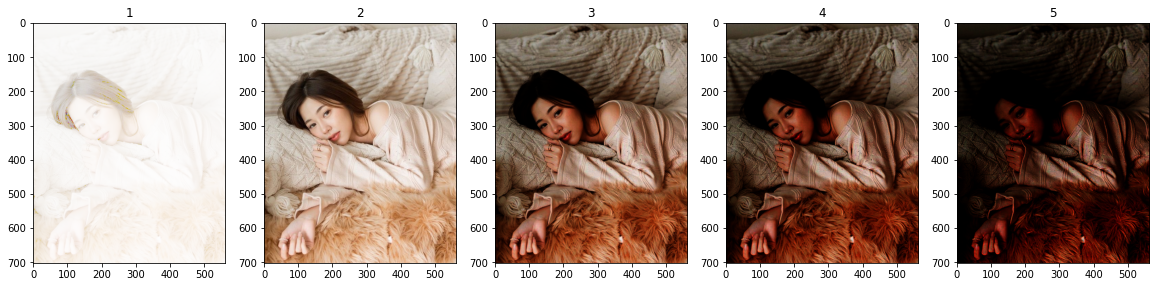

In [689]:
imgs = []
for gm in gamma:
    _img = gamma_adjust(img, gm, a, b)
    imgs.append(_img)

f, ax = plt.subplots(1, 5, figsize=(20, 20))

ax[0].set_title('1')
ax[0].imshow(imgs[0])

ax[1].set_title('2')
ax[1].imshow(imgs[1])

ax[2].set_title('3')
ax[2].imshow(imgs[2])

ax[3].set_title('4')
ax[3].imshow(imgs[3])

ax[4].set_title('5')
ax[4].imshow(imgs[4])
plt.show()

# Make video

In [690]:
print(src.shape[1], src.shape[0])

# Make Video
def write_video(file_path, frames, fps):
    w, h = src.shape[1], src.shape[0] # width = 563 and height = 702
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    writer = cv2.VideoWriter(file_path, fourcc, fps, (w, h))

    for frame in frames:
        writer.write(frame)

    writer.release()

563 702


In [691]:
# Parameters
a = 1.0
b = 0
frames = []
fps = 30
second = 5
gmMax = 3
stepper = gmMax / (second * fps)
gm = 0
# Forward
while(gm <= gmMax):
    # don't need to convert from BGR -> RGB
    # frames.append(img)
    _img = gamma_adjust(src, gm, a, b) # maybe round(gm, 2) ?
    frames.append(_img)
    gm += stepper

# Backward
frames += frames[::-1]

In [692]:
write_video('activity3.mp4', frames, fps)

# 3.2 Image Histogram Equalization

In [693]:
def plotHist(img, _plt):
    color = ('r', 'g', 'b')
    for i, col in enumerate(color):
        histr = cv2.calcHist([img], [i], None, [256], [0,256])
        _plt.plot(histr, color = col)


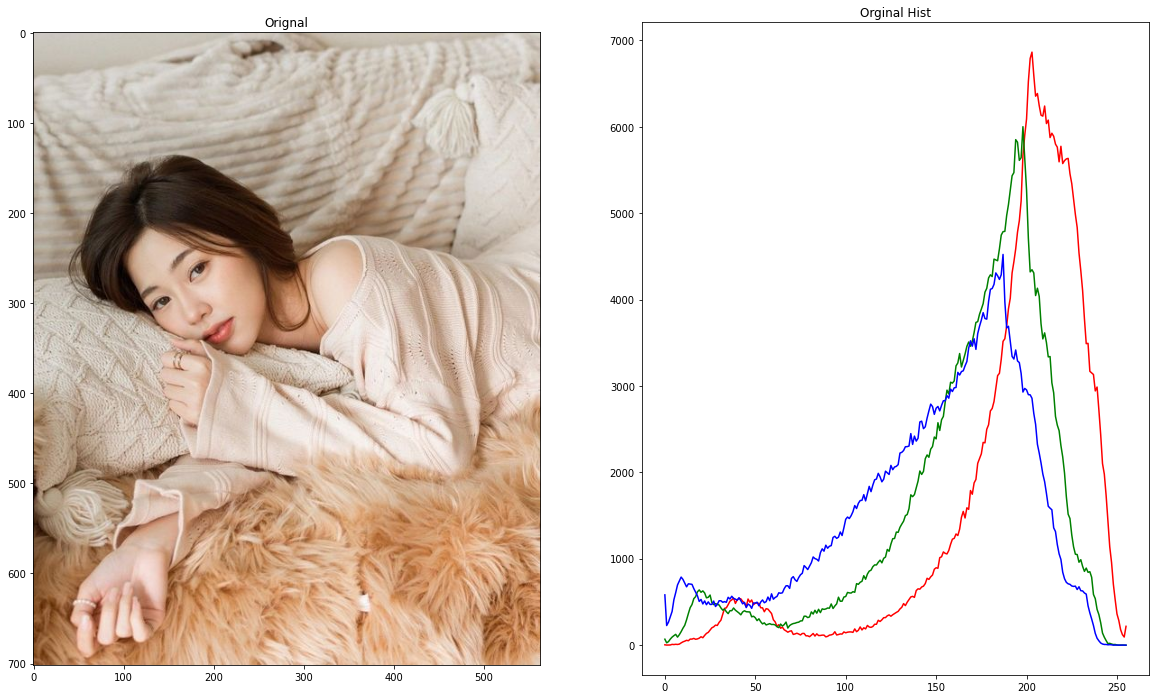

In [694]:
f, ax = plt.subplots(1, 2, figsize=(20, 12))

ax[0].set_title('Orignal')
ax[0].imshow(img)

ax[1].set_title('Orginal Hist')
plotHist(img,ax[1])


plt.show()

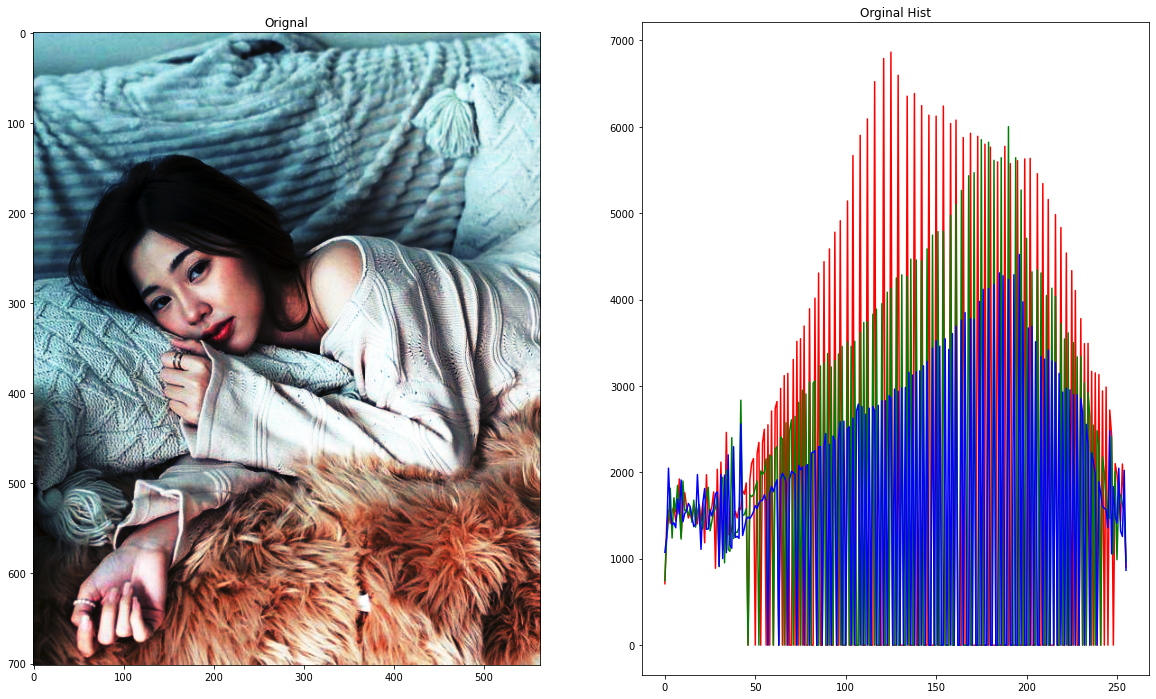

In [695]:
equs = []
for i in range(3):
    equ = cv2.equalizeHist(img[:, :, i])
    equs.append(equ)

img_equalized = cv2.merge([equs[0], equs[1], equs[2]])
f, ax = plt.subplots(1, 2, figsize=(20, 12))

ax[0].set_title('Orignal')
ax[0].imshow(img_equalized)

ax[1].set_title('Orginal Hist')
plotHist(img_equalized, ax[1])

plt.show()

# 3.3 Image Histogram Matching

In [696]:
src2 = cv2.imread('./img2.jpg');
img2 = cv2.cvtColor(src2,cv2.COLOR_BGR2RGB);
print(src.shape[0], src.shape[1])

702 563


In [697]:
def cdf(im):
    c, b = exposure.cumulative_distribution(im)
    #print(b)
    for i in range(b[0]):
        c = np.insert(c, 0, 0)
    for i in range(b[-1]+1, 256):
        c = np.append(c, 1)
    return c

In [698]:
def hist_matching(c, c_t, im): #cdf i/p, cdf template, input img
    b = np.interp(c, c_t, np.arange(256))
    pix_repl = {i:b[i] for i in range(256)}
    mp = np.arange(0,256)
    for (k, v) in pix_repl.items():
        mp[k] = v
    s = im.shape
    im = np.reshape(mp[im.ravel()], im.shape)
    im = np.reshape(im, s)
    return im

In [699]:
cdf_img1_R = cdf(img[:,:, 0])
cdf_img1_G = cdf(img[:,:, 1])
cdf_img1_B = cdf(img[:,:, 2])
cdf_img2_R = cdf(img2[:,:, 0])
cdf_img2_G = cdf(img2[:,:, 1])
cdf_img2_B = cdf(img2[:,:, 2])

process_R = hist_matching(cdf_img1_R, cdf_img2_R, img[:, :, 0])
process_G = hist_matching(cdf_img1_G, cdf_img2_G, img[:, :, 1])
process_B = hist_matching(cdf_img1_B, cdf_img2_B, img[:, :, 2])

process_img = cv2.merge([process_R, process_G, process_B])




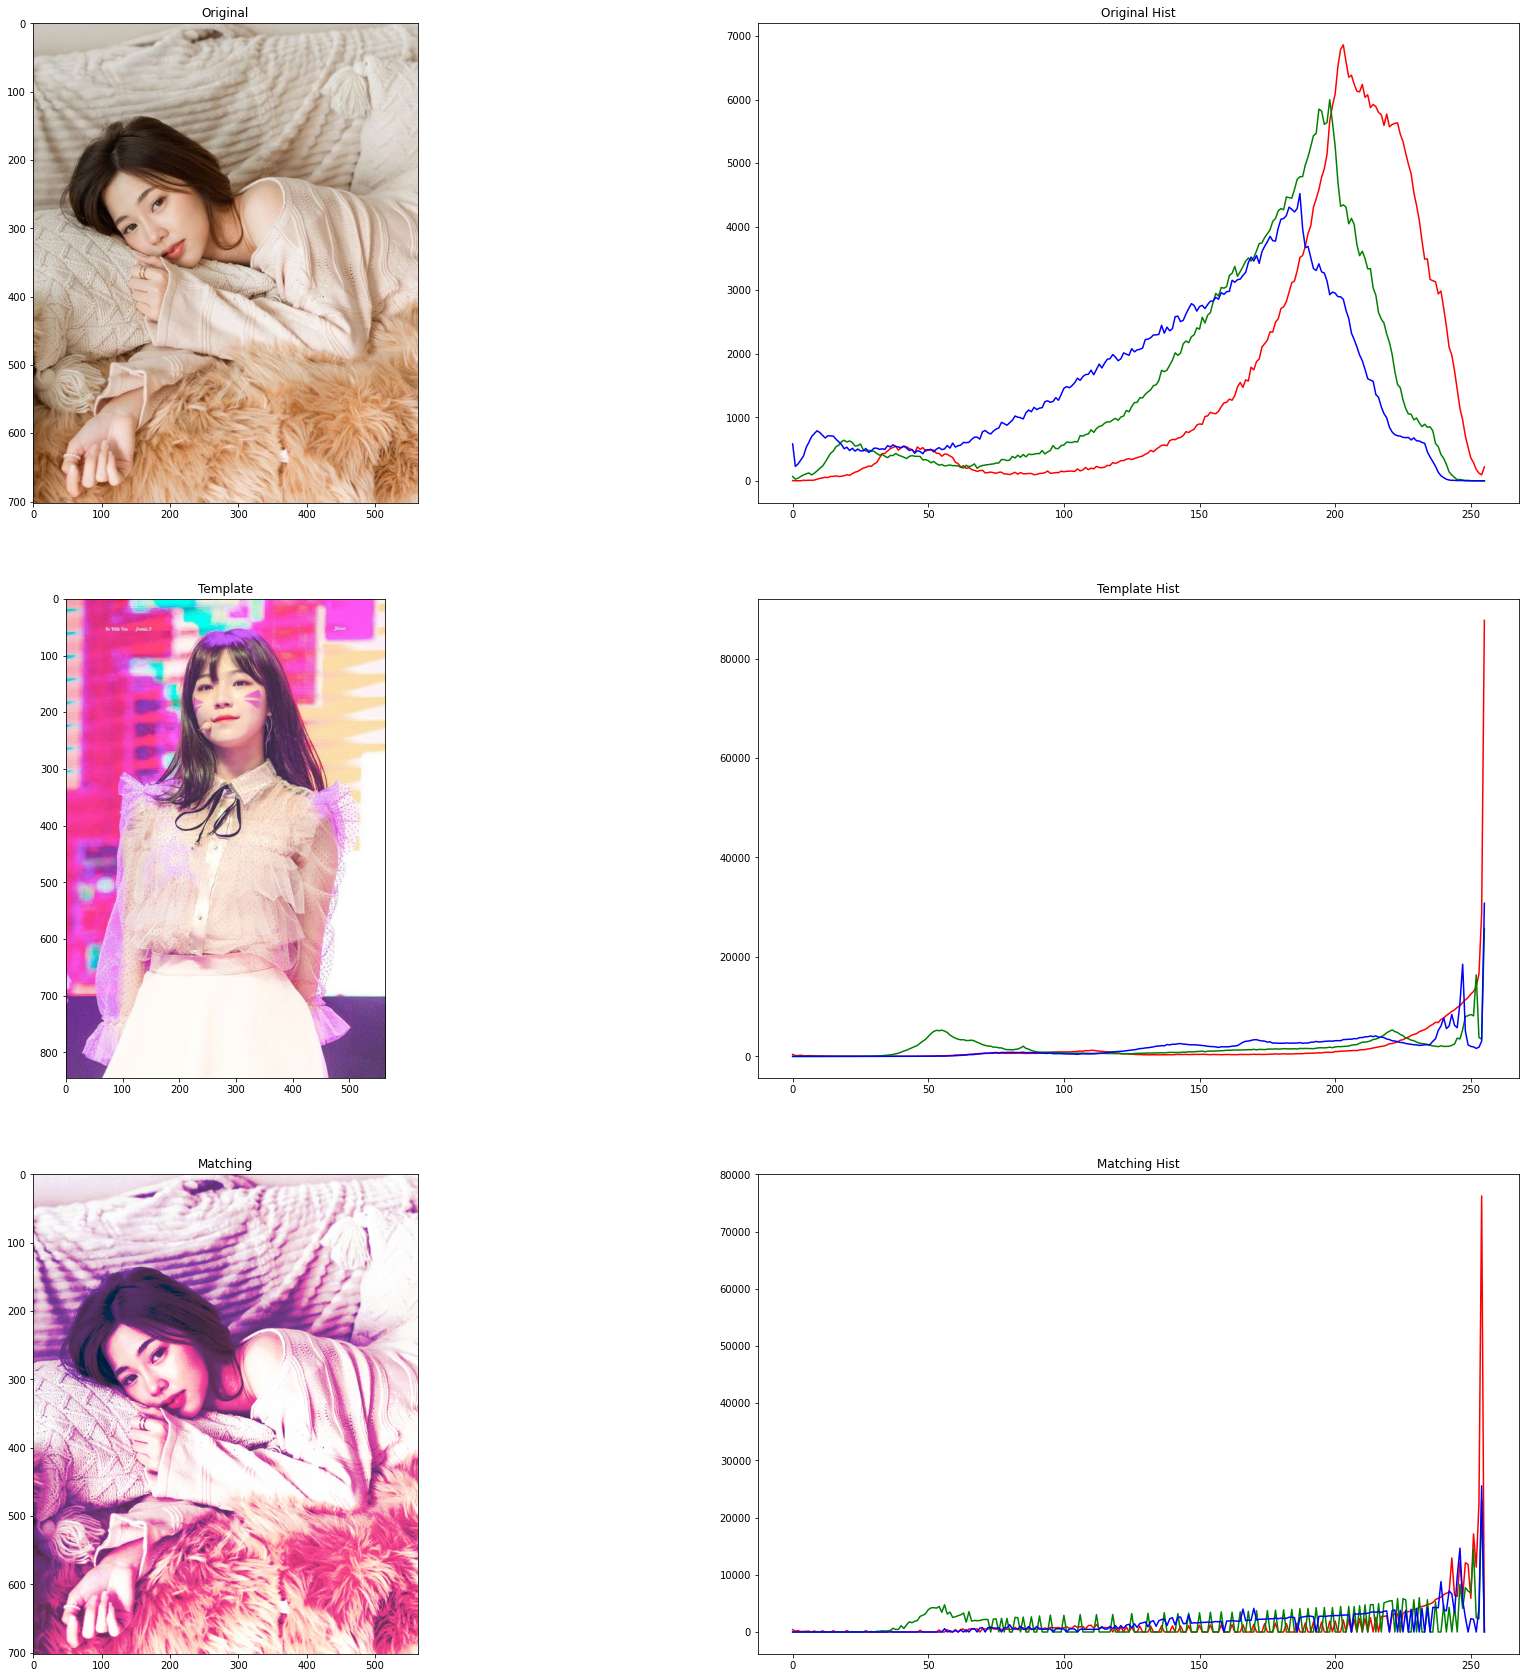

In [700]:
f, ax = plt.subplots(3, 2, figsize=(30, 30)) # , 

ax[0,0].set_title('Original')
ax[0,0].imshow(img)
ax[0,1].set_title('Original Hist')
plotHist(img, ax[0, 1])

ax[1,0].set_title('Template')
ax[1,0].imshow(img2)
ax[1,1].set_title('Template Hist')
plotHist(img2, ax[1, 1])

ax[2,0].set_title('Matching')
ax[2,0].imshow(process_img)
ax[2,1].set_title('Matching Hist')
plotHist(process_img.astype(np.uint8), ax[2, 1])

plt.show()